## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
wdi_df = pd.read_csv("data/WDIData.csv")
wdi_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.580366,11.907943,12.285175,12.607641,12.990589,13.394404,13.835255,14.257120,14.687203,15.124112,15.545214,16.028677,16.447499,16.914625,17.392349,17.892005,18.359993,18.795151,19.295176,19.788156,20.279599,20.773627,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.546244,3.713752,3.904902,4.093657,4.312080,4.530435,4.759641,5.004145,5.237581,5.483481,5.733854,5.957514,6.224276,6.473301,6.720331,7.015917,7.281390,7.513673,7.809566,8.075889,8.366010,8.684137,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.604500,32.964159,33.409617,33.791497,34.220485,34.727444,35.159518,35.694984,36.102188,36.447583,36.849648,37.180314,37.540749,37.870347,38.184152,38.543180,38.801719,39.039014,39.323186,39.643848,39.894830,40.213891,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.957302,19.975365,21.576500,22.529265,23.749531,23.493013,25.191221,26.807937,25.943316,26.193895,27.400110,28.914348,31.666928,31.695183,31.859257,33.903515,38.851444,40.197332,43.028332,44.389773,46.268621,48.103609,NaN,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.623497,NaN,NaN,9.765491,10.910243,10.442796,12.518041,12.527150,12.986509,15.527791,14.462760,16.100904,19.375171,18.672306,17.623956,16.516633,24.594474,25.389297,27.041743,29.138285,30.998687,32.772690,NaN,NaN


In [3]:
wdi_df.drop('Unnamed: 67', axis=1, inplace=True)

In [4]:
id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']

wdi_melt = pd.melt(wdi_df, 
                   id_vars=id_vars, 
                   var_name='Years', 
                   value_name='Score')
wdi_melt.head()

,Country Name,Country Code,Indicator Name,Indicator Code,Years,Score
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,1960,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,1960,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


In [5]:
series_df = pd.read_csv("data/WDISeries.csv")
series_df.head(2)

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,AG.AGR.TRAC.NO,Environment: Agricultural production,"Agricultural machinery, tractors",NaN,Agricultural machinery refers to the number of...,NaN,Annual,NaN,NaN,Sum,The data are collected by the Food and Agricul...,NaN,NaN,"Food and Agriculture Organization, electronic ...",A tractor provides the power and traction to m...,Agricultural land covers more than one-third o...,NaN,NaN,NaN,CC BY-4.0,NaN
1,AG.CON.FERT.PT.ZS,Environment: Agricultural production,Fertilizer consumption (% of fertilizer produc...,NaN,Fertilizer consumption measures the quantity o...,NaN,Annual,NaN,The world and regional aggregate series do not...,Weighted average,The FAO has revised the time series for fertil...,NaN,NaN,"Food and Agriculture Organization, electronic ...",Fertilizer consumption measures the quantity o...,"Factors such as the green revolution, has led ...",NaN,NaN,NaN,CC BY-4.0,NaN


In [6]:
eastern_countries = [
"Djibouti",
"Eritrea",
"Ethiopia",
"Kenya",
"Rwanda",
"Sudan",
"Tanzania",
"Uganda"]

eastern_df = wdi_melt[wdi_melt['Country Name'].isin(eastern_countries)]
print(eastern_df.shape)
eastern_df.head()

(744408, 6)


,Country Name,Country Code,Indicator Name,Indicator Code,Years,Score
152131,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,1960,NaN
152132,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,1960,NaN
152133,Djibouti,DJI,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,1960,NaN
152134,Djibouti,DJI,Access to electricity (% of population),EG.ELC.ACCS.ZS,1960,NaN
152135,Djibouti,DJI,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,1960,NaN


In [7]:
expenditure = [i for i in eastern_df['Indicator Name'] if 'expenditure' in i]
expenditure_df = eastern_df[eastern_df['Indicator Name'].isin(expenditure)]
expenditure_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42840 entries, 152167 to 24730622
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    42840 non-null  object 
 1   Country Code    42840 non-null  object 
 2   Indicator Name  42840 non-null  object 
 3   Indicator Code  42840 non-null  object 
 4   Years           42840 non-null  object 
 5   Score           15662 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.3+ MB


In [8]:
expenditure_df = expenditure_df[(expenditure_df['Years'] >= '2010') & (expenditure_df['Years'] <= '2020')]

In [9]:
merged_df = pd.merge(expenditure_df, 
                     series_df,
                     left_on="Indicator Code",
                     right_on="Series Code",
                     how='left')
merged_df.head(2)

,Country Name,Country Code,Indicator Name_x,Indicator Code,Years,Score,Series Code,Topic,Indicator Name_y,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
0,Djibouti,DJI,Adjusted savings: education expenditure (% of ...,NY.ADJ.AEDU.GN.ZS,2010,7.802883e+00,NY.ADJ.AEDU.GN.ZS,Economic Policy & Debt: National accounts: Adj...,Adjusted savings: education expenditure (% of ...,NaN,Education expenditure refers to the current op...,NaN,Annual,NaN,NaN,Weighted average,Public education expenditures are considered a...,NaN,NaN,World Bank staff estimates using data from the...,NaN,NaN,NaN,NaN,NaN,CC BY-4.0,NaN
1,Djibouti,DJI,Adjusted savings: education expenditure (curre...,NY.ADJ.AEDU.CD,2010,8.941872e+07,NY.ADJ.AEDU.CD,Economic Policy & Debt: National accounts: Adj...,Adjusted savings: education expenditure (curre...,NaN,Education expenditure refers to the current op...,NaN,Annual,NaN,NaN,NaN,NaN,NaN,NaN,World Bank staff estimates using data from the...,NaN,NaN,NaN,NaN,NaN,CC BY-4.0,NaN


In [10]:
neccessary_columns = ['Country Name', 'Indicator Name_x', 'Topic', 'Years', 'Score']

merged_df = merged_df[neccessary_columns]
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country Name      7480 non-null   object 
 1   Indicator Name_x  7480 non-null   object 
 2   Topic             7480 non-null   object 
 3   Years             7480 non-null   object 
 4   Score             5057 non-null   float64
dtypes: float64(1), object(4)
memory usage: 292.3+ KB


In [11]:
indicators = ['Current health expenditure (% of GDP)',
'Domestic general government health expenditure (% of current health expenditure)',
'Domestic general government health expenditure (% of GDP)',
'Domestic general government health expenditure (% of general government expenditure)',
'Domestic private health expenditure (% of current health expenditure)',
'External health expenditure (% of current health expenditure)',
'Out-of-pocket expenditure (% of current health expenditure)']
health_df = merged_df[merged_df['Indicator Name_x'].isin(indicators)]
health_df.head()

,Country Name,Indicator Name_x,Topic,Years,Score
6,Djibouti,Current health expenditure (% of GDP),Health: Health systems,2010,3.061504
11,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,60.679157
12,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,1.857695
13,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,6.970487
16,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,2010,29.537765


In [12]:
health_df.head()

,Country Name,Indicator Name_x,Topic,Years,Score
6,Djibouti,Current health expenditure (% of GDP),Health: Health systems,2010,3.061504
11,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,60.679157
12,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,1.857695
13,Djibouti,Domestic general government health expenditure...,Health: Health systems,2010,6.970487
16,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,2010,29.537765


In [13]:
health_df['Years'] = pd.to_datetime(health_df['Years'])
health_df.set_index('Years', inplace=True)
health_df.tail()

,Country Name,Indicator Name_x,Topic,Score
Years,,,,
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,0.672564
2020-01-01,Uganda,Domestic general government health expenditure...,Health: Health systems,3.138830
2020-01-01,Uganda,Domestic private health expenditure (% of curr...,Health: Health systems,41.942467
2020-01-01,Uganda,External health expenditure (% of current heal...,Health: Health systems,41.082459
2020-01-01,Uganda,Out-of-pocket expenditure (% of current health...,Health: Health systems,37.445602


In [14]:
# Renaming columns
health_df.rename(columns={
    'Country Name': 'Country',
    'Indicator Name_x': 'Indicator Name',
    'Score' : 'Percentage'
}, inplace=True)
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


In [15]:
def create_dfs(df):
    indicators = [i for i in df['Indicator Name'].unique()]
    dfs = {}
    for i in indicators:
        dfs[i] = df[df['Indicator Name'] == i]
    return dfs

def create_country_dfs(df):
    countries = [country for country in df['Country'].unique()]
    indicator_dfs = create_dfs(df) 
    country_dfs = {}
    
    for c in countries:
        country_dfs[c] = {} 
        for indicator, indicator_df in indicator_dfs.items():
            country_df = indicator_df[indicator_df['Country'] == c]
            country_df['Percentage Diff'] = country_df['Percentage'].diff()
            country_df['Percentage Diff'] = country_df['Percentage Diff'].fillna(0)
            country_dfs[c][indicator] = country_df
            
    return country_dfs

In [16]:
countries = create_country_dfs(health_df)
indicators = create_dfs(health_df)

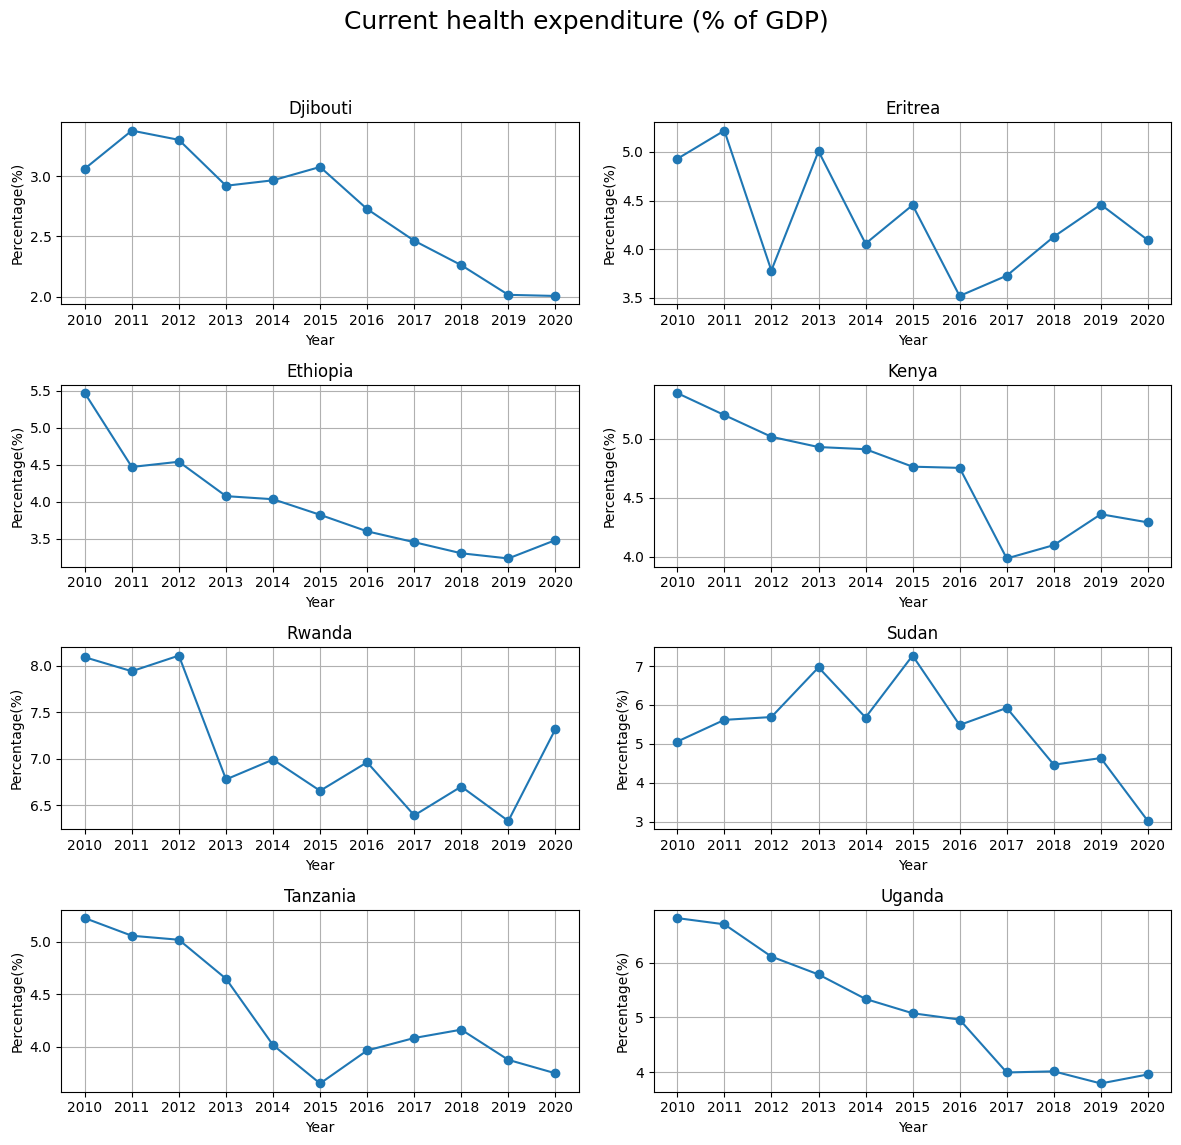

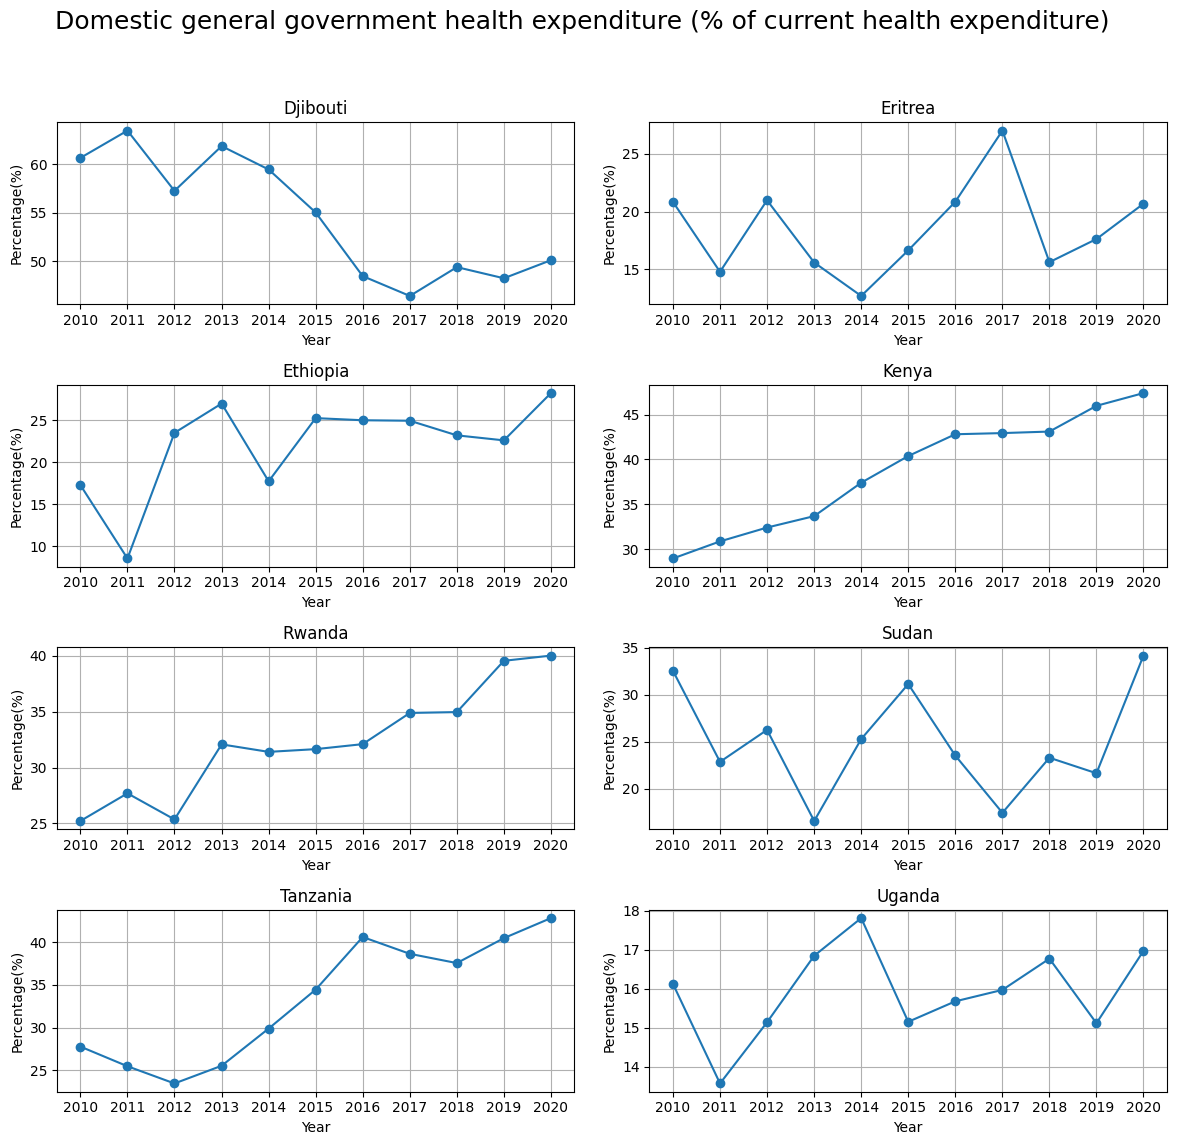

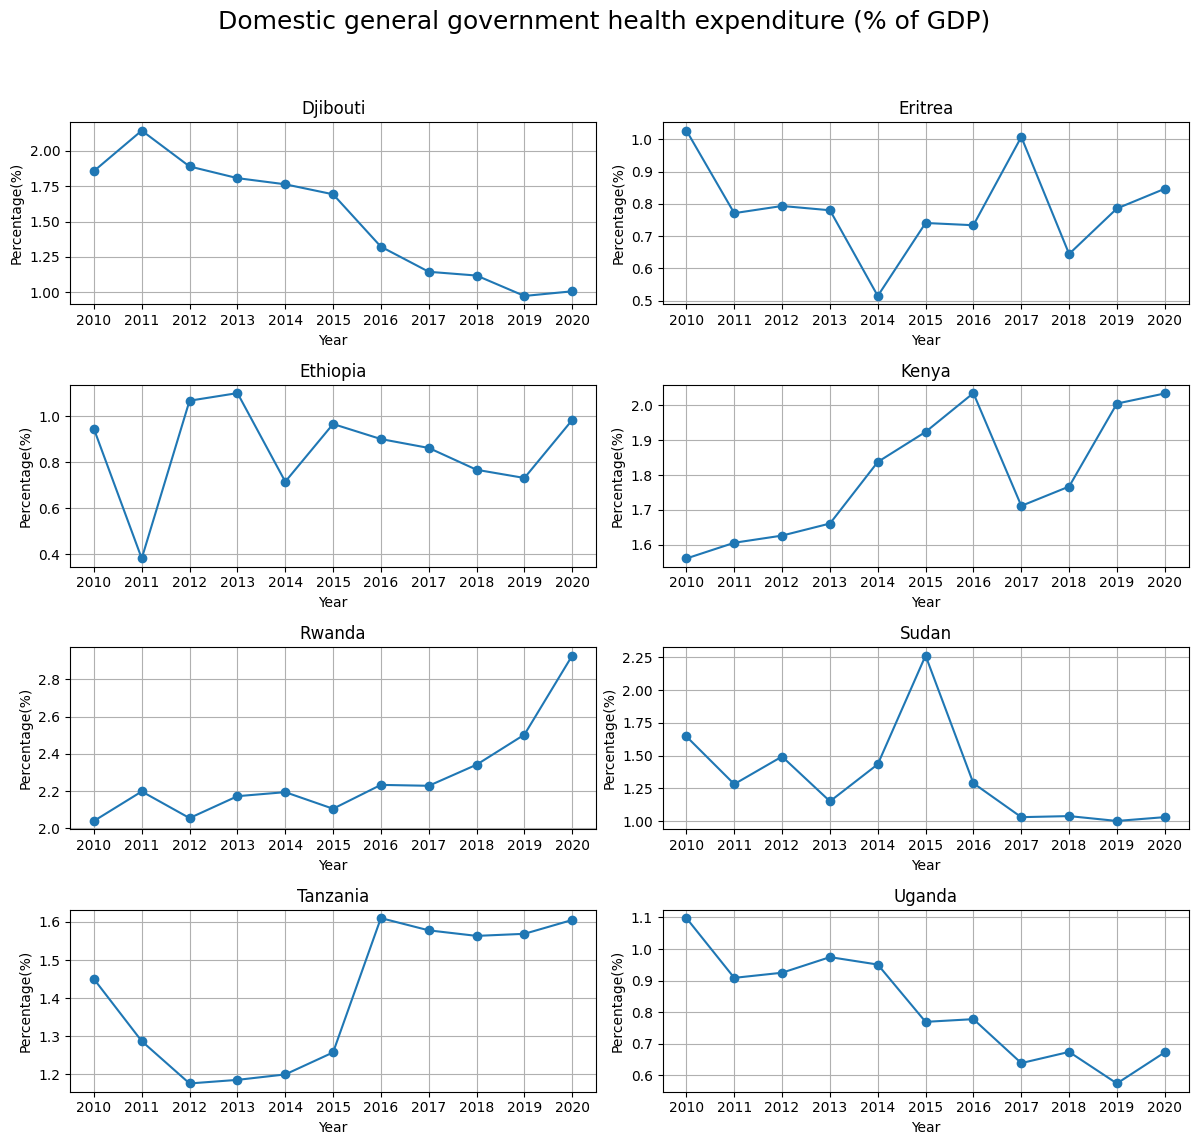

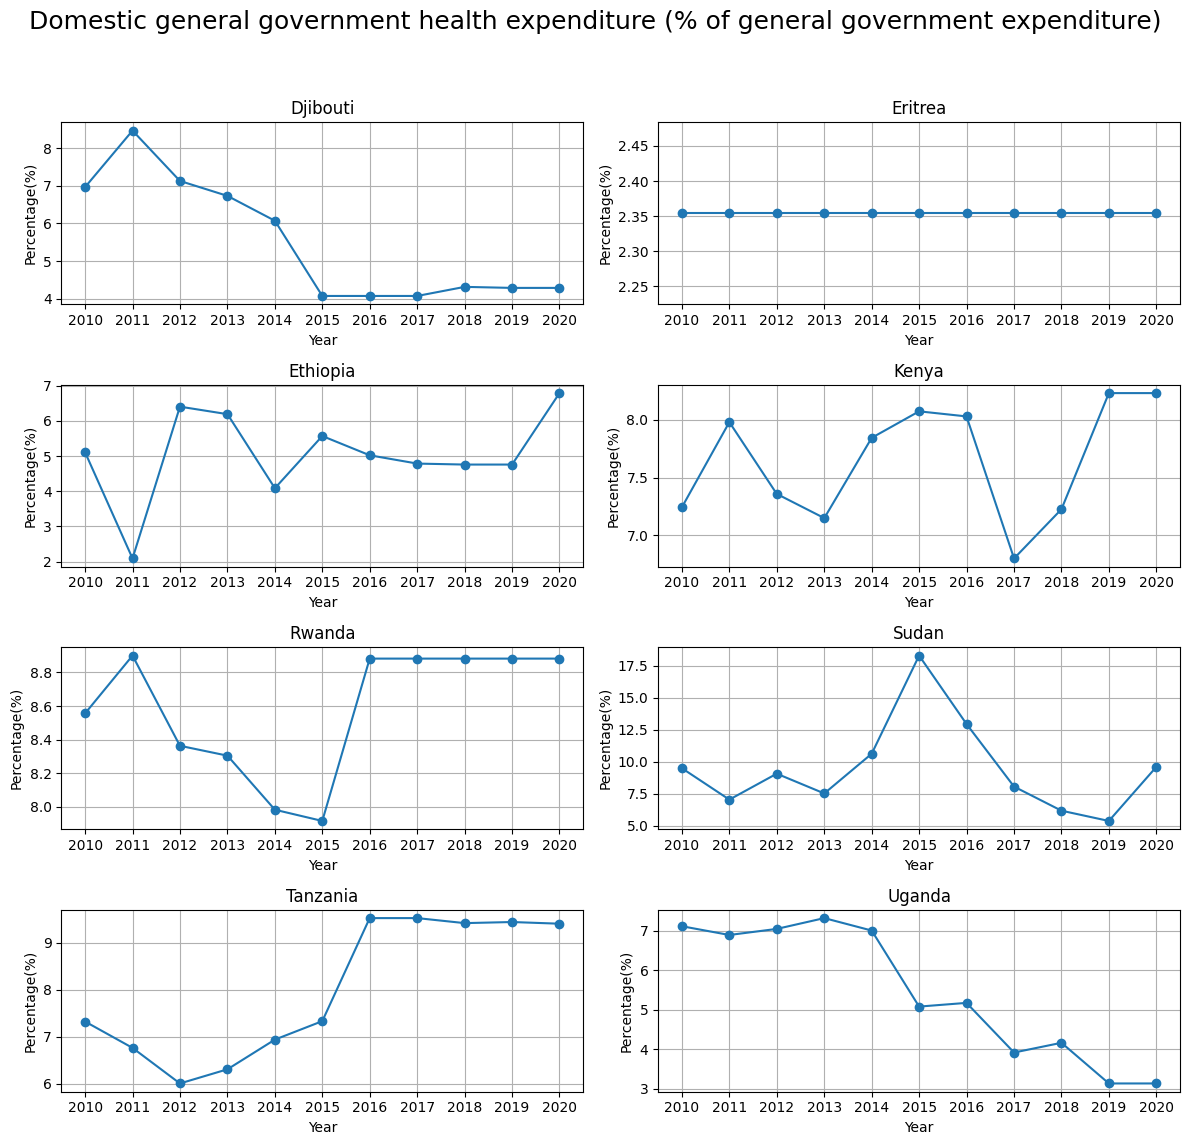

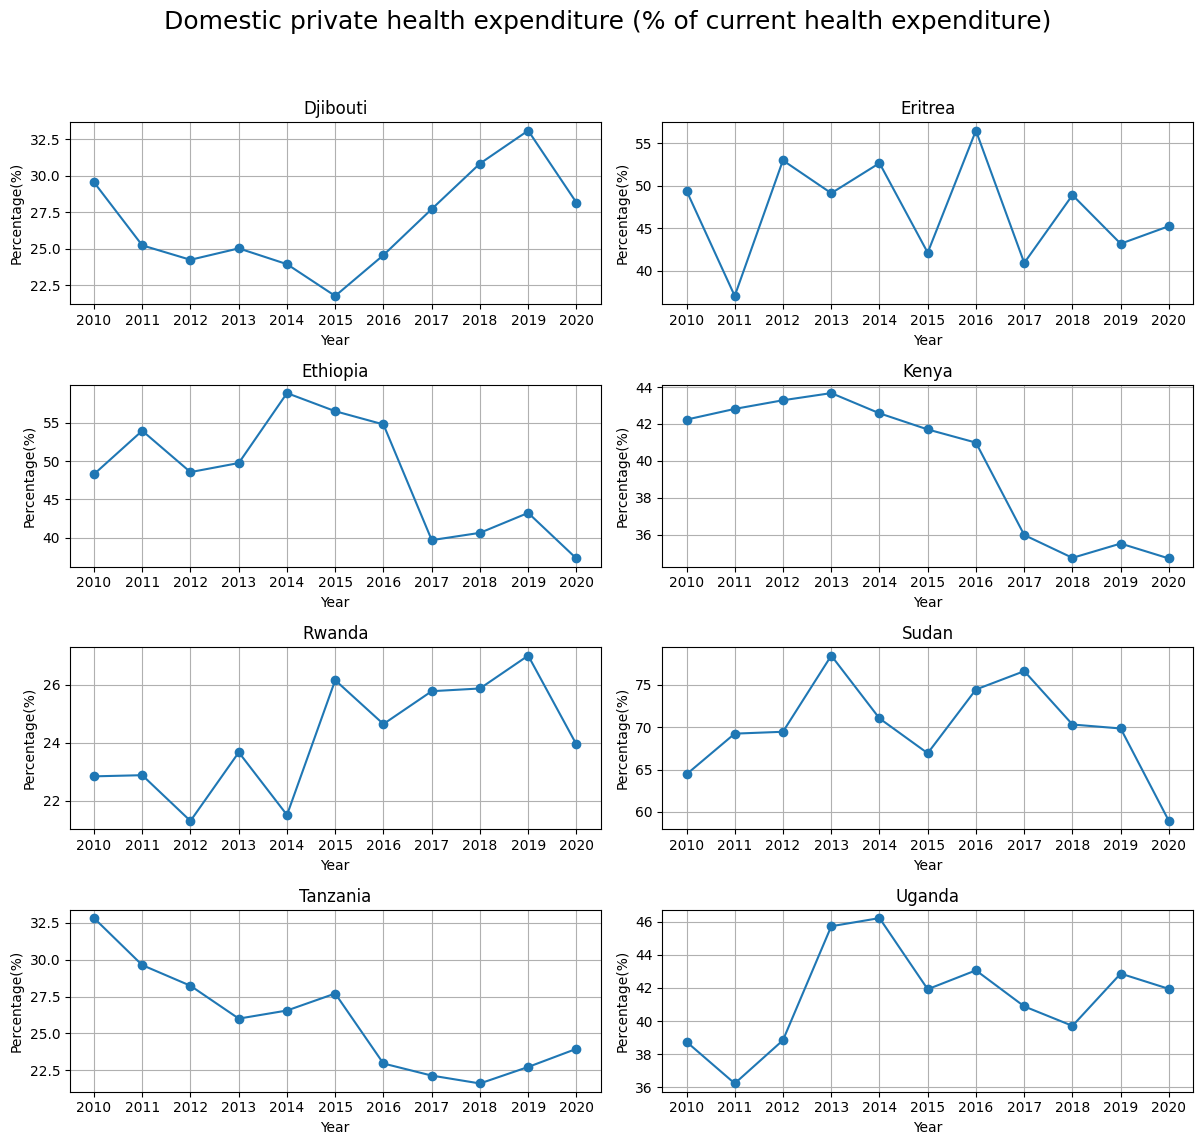

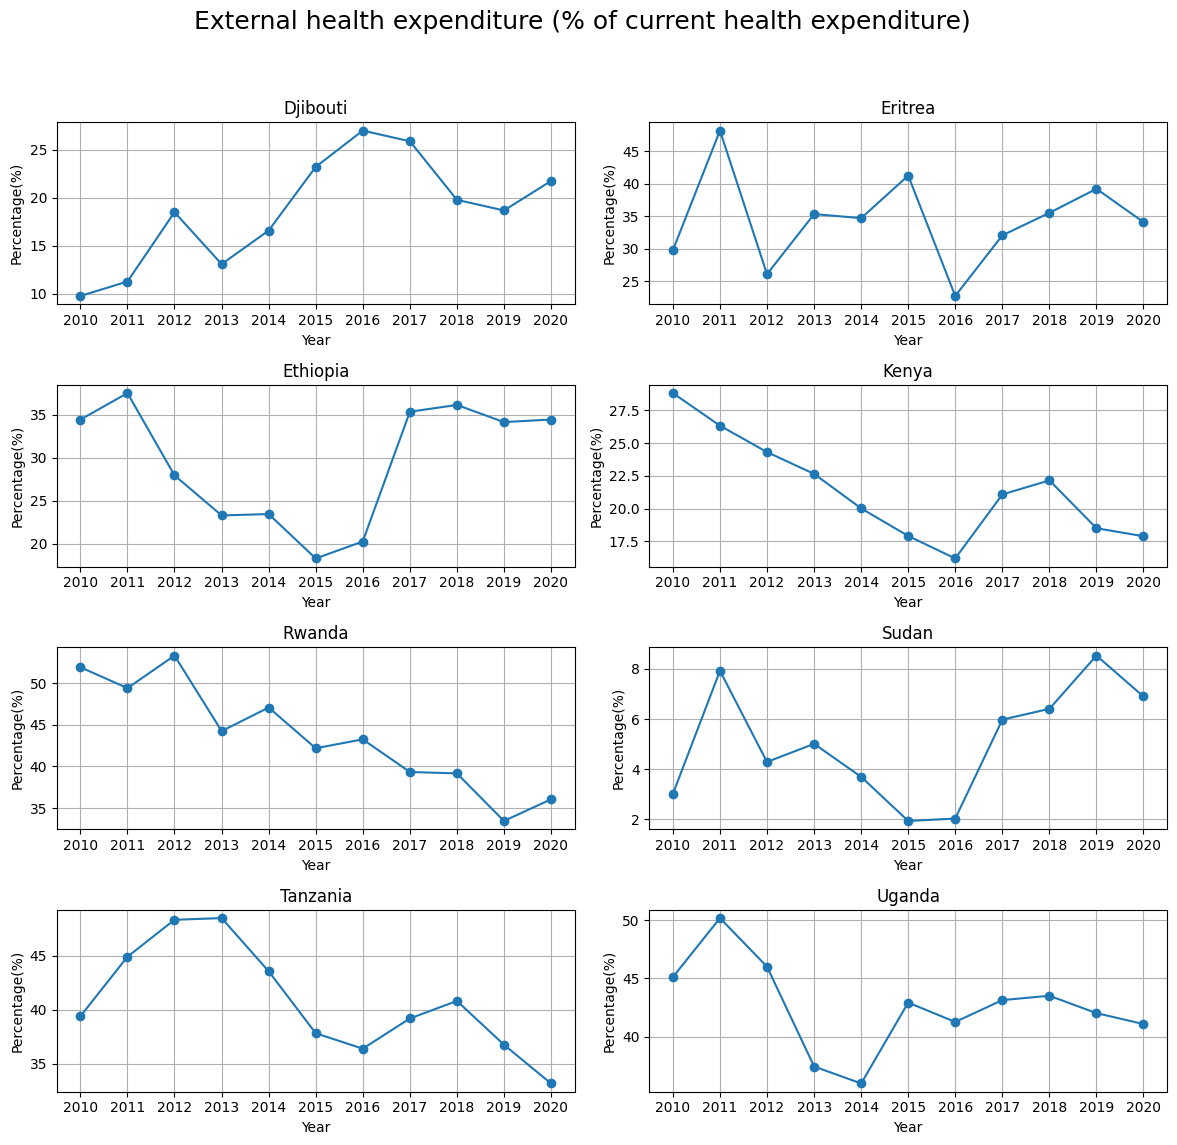

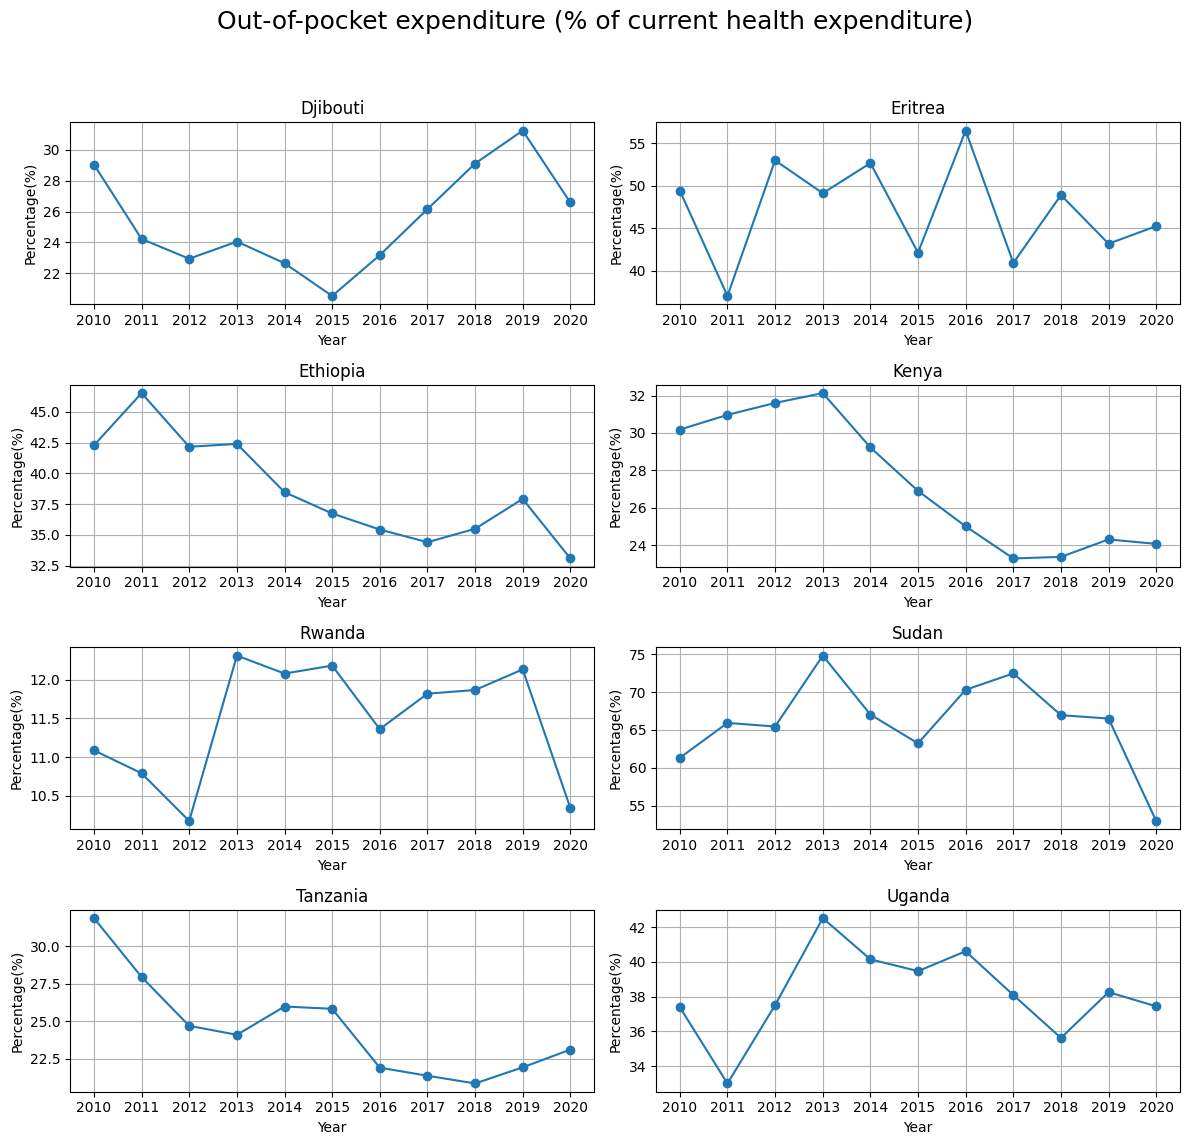

In [17]:

def plot(df, ax, indicator, country):
    ax.plot(df.index, df['Percentage'], marker='o', label=indicator)
    ax.set_title(f'{country}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Percentage(%)')
    ax.grid(True)
    # ax.legend()

# Retrieve country-specific data
country_dfs = create_country_dfs(health_df)

# List of indicators
indicators = [
'Current health expenditure (% of GDP)',
'Domestic general government health expenditure (% of current health expenditure)',
'Domestic general government health expenditure (% of GDP)',
'Domestic general government health expenditure (% of general government expenditure)',
'Domestic private health expenditure (% of current health expenditure)',
'External health expenditure (% of current health expenditure)',
'Out-of-pocket expenditure (% of current health expenditure)'
]

# Iterate over the indicators and plot the data for each country
for indicator in indicators:
    # Create a figure with subplots
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 12))

    # Add a main title to the figure
    fig.suptitle(f'{indicator}', fontsize=18)

    # Iterate over the subplots and plot the data for each country
    for i, (country, country_data) in enumerate(country_dfs.items()):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        if indicator in country_data:
            plot(country_data[indicator], ax, indicator, country)

    # Adjust the layout to prevent titles from overlapping
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot
    plt.show()

#### Time Series Analysis

In [18]:
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


In [19]:
def adf_test_indicator(df, country):
    country_df = df[df['Country'] == country]
    indicator_results = {}
    
    unique_indicators = country_df['Indicator Name'].unique()
    for indicator in unique_indicators:
        indicator_data = country_df[country_df['Indicator Name'] == indicator]['Percentage']
        
        # Check if the data is constant
        if indicator_data.var() == 0:
            continue  # Skip the Dickey-Fuller test
        
        # Perform the Dickey-Fuller test
        result = adfuller(indicator_data)
        
        # Store the result in the dictionary
        indicator_results[indicator] = {
            'ADF Statistic': result[0],
            'P-value': result[1],
            'Critical Values': result[4]
        }
    
    return indicator_results


In [20]:
health_df[health_df['Country'] == 'Eritrea']

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Eritrea,Current health expenditure (% of GDP),Health: Health systems,4.929461
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,20.832497
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,1.026930
2010-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,2.354107
2010-01-01,Eritrea,Domestic private health expenditure (% of curr...,Health: Health systems,49.408188
...,...,...,...,...
2020-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,0.846498
2020-01-01,Eritrea,Domestic general government health expenditure...,Health: Health systems,2.354107
2020-01-01,Eritrea,Domestic private health expenditure (% of curr...,Health: Health systems,45.249561


In [21]:
countries = ['Tanzania', 'Kenya', 'Uganda', 'Rwanda', 'Ethiopia','Sudan']
results = {}

for country in countries:
    country_results = adf_test_indicator(health_df, country)
    results[country] = list(country_results.items())

# Print the stationarity results for all countries
for country, country_results in results.items():
    print(f"Indicators in {country} and stationarity:")
    for indicator, result in country_results:
        print(f"{indicator}:")
        if result['ADF Statistic'] < result['Critical Values']['1%'] and result['P-value'] < 0.05:
            print("Stationary")
        else:
            print("Not Stationary")
        print()

Indicators in Tanzania and stationarity:
Current health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of current health expenditure):
Not Stationary

Domestic general government health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of general government expenditure):
Not Stationary

Domestic private health expenditure (% of current health expenditure):
Not Stationary

External health expenditure (% of current health expenditure):
Not Stationary

Out-of-pocket expenditure (% of current health expenditure):
Not Stationary

Indicators in Kenya and stationarity:
Current health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of current health expenditure):
Not Stationary

Domestic general government health expenditure (% of GDP):
Not Stationary

Domestic general government health expenditure (% of general government expenditure):
Not Stationary

Domestic private h

### MODELLING

#### Splitting into train and test dataset

In [22]:
health_df.head()

,Country,Indicator Name,Topic,Percentage
Years,,,,
2010-01-01,Djibouti,Current health expenditure (% of GDP),Health: Health systems,3.061504
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,60.679157
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,1.857695
2010-01-01,Djibouti,Domestic general government health expenditure...,Health: Health systems,6.970487
2010-01-01,Djibouti,Domestic private health expenditure (% of curr...,Health: Health systems,29.537765


#### Splitting the Data

In [23]:
# Splitting the data
train_ratio = 0.8  # Specify the ratio of training data
split_index = int(len(health_df) * train_ratio)  # Calculate the index to split the data

train_data = health_df[:split_index]
test_data = health_df[split_index:]

#### Differencing the data

In [25]:
# Splits input data indicators by country
def split_data(country):
    differenced_test_data = create_country_dfs(test_data)[country]
    differenced_train_data = create_country_dfs(train_data)[country]
    return differenced_test_data,differenced_train_data


#### Tanzania

In [26]:
# Training data and testing data for Tanzania
tanzania_df = split_data('Tanzania')
training_data = tanzania_df[1]
testing_data = tanzania_df[0]

In [27]:
training_data['Current health expenditure (% of GDP)']

,Country,Indicator Name,Topic,Percentage,Percentage Diff
Years,,,,,
2010-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,5.223922,0.000000
2011-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,5.055985,-0.167937
2012-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,5.017794,-0.038191
2013-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,4.646434,-0.371360
2014-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,4.014921,-0.631513
2015-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,3.649699,-0.365221
2016-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,3.963503,0.313804
2017-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,4.082574,0.119071
2018-01-01,Tanzania,Current health expenditure (% of GDP),Health: Health systems,4.161917,0.079342


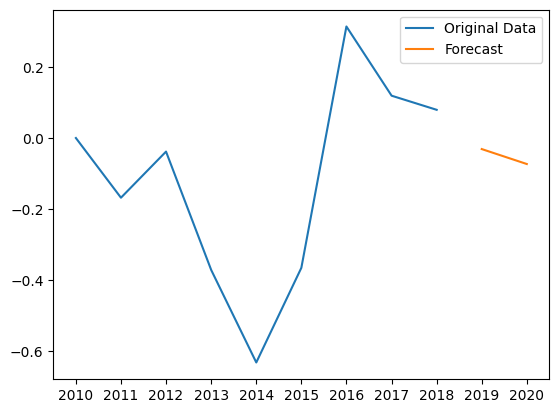

In [28]:
# Fit the ARIMA model
model = sm.tsa.ARIMA(training_data['Current health expenditure (% of GDP)']['Percentage Diff'], order=(1,0,0))
results = model.fit()

# Make predictions
forecast = results.forecast(steps=len(testing_data['Current health expenditure (% of GDP)']))

# Evaluate and visualize predictions
plt.plot(training_data['Current health expenditure (% of GDP)']['Percentage Diff'], label='Original Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()

In [30]:
train_dict = {}
test_dict = {}

for indicator in training_data.keys():
    # Fit the ARIMA model
    model = sm.tsa.ARIMA(training_data[indicator]['Percentage Diff'], order=(1, 0, 0))
    results = model.fit()

    # Make predictions
    test_forecast = results.forecast(steps=len(testing_data[indicator]))
    train_forecast = results.forecast(steps=len(training_data[indicator]))

    # Evaluate
    train_rmse = mean_squared_error(training_data[indicator]['Percentage Diff'], train_forecast, squared=False)
    test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

    train_dict[indicator] = train_rmse
    test_dict[indicator] = test_rmse


In [41]:
def arima_model(country, order = (1, 0, 0)):
    data = split_data(country)
    training_data = data[1]
    testing_data = data[0]

    train_rmse_dict = {}
    test_rmse_dict = {}

    for indicator in training_data.keys():
        # Fit the ARIMA model
        model = sm.tsa.ARIMA(training_data[indicator]['Percentage Diff'], order = order)
        results = model.fit()

        # Make predictions
        test_forecast = results.forecast(steps=len(testing_data[indicator]))
        train_forecast = results.forecast(steps=len(training_data[indicator]))

        # Evaluate
        train_rmse = mean_squared_error(training_data[indicator]['Percentage Diff'], train_forecast, squared=False)
        test_rmse = mean_squared_error(testing_data[indicator]['Percentage Diff'], test_forecast, squared=False)

        train_rmse_dict[indicator] = train_rmse
        test_rmse_dict[indicator] = test_rmse
        
    result_str = "ARIMA Model Results:\n\n"
    result_str += "Train RMSE:\n"
    for indicator, rmse in train_rmse_dict.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    result_str += "\n"
    result_str += "Test RMSE:\n"
    for indicator, rmse in test_rmse_dict.items():
        result_str += f"{indicator}: {rmse:.4f}\n"

    return result_str

In [43]:
print(arima_model('Tanzania'))

ARIMA Model Results:

Train RMSE:
Current health expenditure (% of GDP): 0.2778
Domestic general government health expenditure (% of current health expenditure): 3.0484
Domestic general government health expenditure (% of GDP): 0.1439
Domestic general government health expenditure (% of general government expenditure): 0.8439
Domestic private health expenditure (% of current health expenditure): 1.8884
External health expenditure (% of current health expenditure): 3.6248
Out-of-pocket expenditure (% of current health expenditure): 1.9986

Test RMSE:
Current health expenditure (% of GDP): 0.0445
Domestic general government health expenditure (% of current health expenditure): 1.2522
Domestic general government health expenditure (% of GDP): 0.0143
Domestic general government health expenditure (% of general government expenditure): 0.2579
Domestic private health expenditure (% of current health expenditure): 2.2767
External health expenditure (% of current health expenditure): 3.6973
Ou

## LSTM